In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Length of Hospital Stay by Admission Type

For the first visualization, I chose a to explore a simple but informative comparison of information that could be gathered from a single table. Following are two visualizations comparing the distribution of lengths of stay between hospital admission types. This information was found in the [MIMIC III Admissions table](https://mimic.mit.edu/docs/iii/tables/admissions/). Length of Stay was derived by taking the difference between the `DISCHTIME` and `ADMITTIME` columns, using units of hours.

## Histogram View

The first plot is a histogram where the X-Axis represents the length of stay, in hours and the Y-Axis represents the number of admissions with a Length of Stay corresponding to the X-Axis. Length of Stays are "binned" together to make bars. Lenght of Stay counts are stacked by Admission Type

## Violin Plot View

The histogram gives a decent view of the overall distribution, but a violin plot might make it easier to visually compare the distributions per admission type

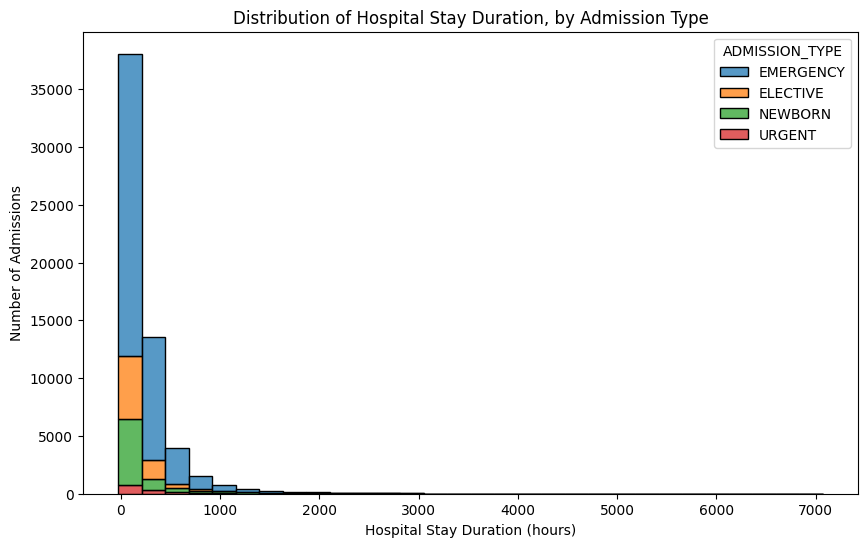

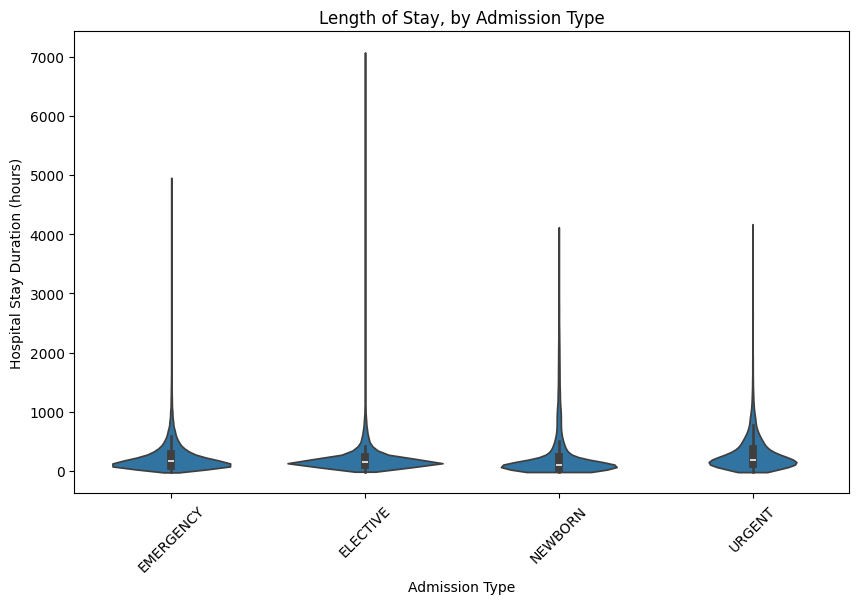

In [22]:
admissions = pd.read_csv("../mimic-iii/ADMISSIONS.csv.gz")

# convert timestamp columns to datetime
admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"])
admissions["DISCHTIME"] = pd.to_datetime(admissions["DISCHTIME"])
# add a column to hold calculated length of stay
admissions["STAYTIME_HRS"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds()/3600

plt.figure(figsize=(10,6))

# Histogram View
sns.histplot(
    data=admissions,
    x="STAYTIME_HRS",
    hue="ADMISSION_TYPE",
    bins=30,
    multiple="stack"
)

plt.xlabel("Hospital Stay Duration (hours)")
plt.ylabel("Number of Admissions")
plt.title("Distribution of Hospital Stay Duration, by Admission Type")
plt.show()

# Violin Plot View
plt.figure(figsize=(10,6))
sns.violinplot(
    data=admissions,
    x="ADMISSION_TYPE",
    y="STAYTIME_HRS",
    inner="box",
    cut=0
)

plt.xlabel("Admission Type")
plt.ylabel("Hospital Stay Duration (hours)")
plt.title("Length of Stay, by Admission Type")
plt.xticks(rotation=45)  # rotate labels if they overlap
plt.show()






# Visualization 2: Admissions and Length of Stay by Age

# Scatter View
This visualization displays a scatter plot with each point representing a patient admission.
The x-axis shows the length of hospital stay (in hours), and the y-axis shows the patient's age at admission (in years).
By plotting age against length of stay, we can explore whether there is any relationship between a patient's age and how long they remain hospitalized. Each point is colored by gender.

It was more challenging than anticipated to determine age at admission because some of the patients' ages were time shifted and others calculated to 0. Such questionable entries were discared from the plot. There is no strong correlation between age and length of stay apparent in this plot.

# Histogram View
This shows the number of admissions by age, again split up by gender. This distribution is not easy to see in the scatterplot above


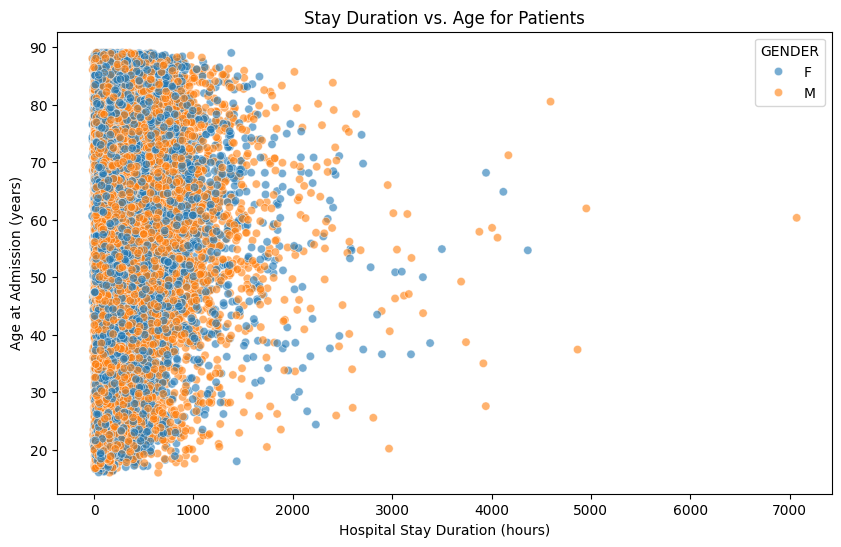

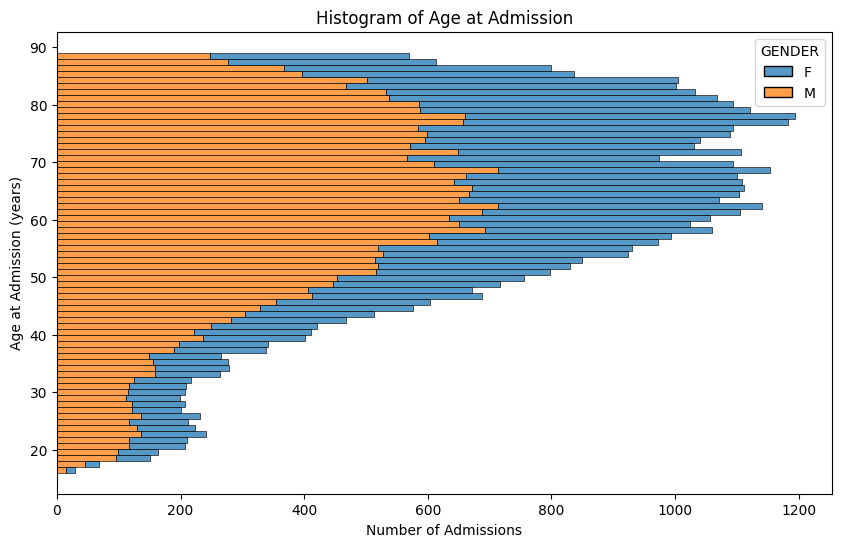

In [25]:
patients = pd.read_csv("../mimic-iii/PATIENTS.csv.gz")
# convert DOB to datetime
patients["DOB"] = pd.to_datetime(patients["DOB"])
# merge to get DOB
adm_with_age = admissions.merge(patients[["SUBJECT_ID", "DOB", "GENDER"]], on="SUBJECT_ID", how="left")

# determine age at admission with steps to avoid int64 overflow

# take just the date part (removes time-of-day; helps avoid tz/ns corner cases)
admit_d = adm_with_age["ADMITTIME"].values.astype('datetime64[D]')
dob_d   = adm_with_age["DOB"].values.astype('datetime64[D]')

# day-precision age calculation (avoids ns overflow)
# Note: result is a numpy timedelta in days; convert to float years
age_days  = (admit_d - dob_d).astype('timedelta64[D]').astype('float')
age_years = age_days / 365.25

# age at admission (years)
adm_with_age["AGE_AT_ADMISSION"] = age_years

# filter out unrealistically old adults
realistic_patients = adm_with_age[adm_with_age["AGE_AT_ADMISSION"] < 120]
realistic_patients = realistic_patients[realistic_patients["AGE_AT_ADMISSION"] > 16]
realistic_patients["AGE_AT_ADMISSION"].describe()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=realistic_patients,
    x="STAYTIME_HRS",
    y="AGE_AT_ADMISSION",
    hue="GENDER",
    alpha=0.6
)
plt.xlabel("Hospital Stay Duration (hours)")
plt.ylabel("Age at Admission (years)")
plt.title("Stay Duration vs. Age for Patients")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(
        data=realistic_patients,
        y="AGE_AT_ADMISSION",
        hue="GENDER",
        bins=70,
        multiple="stack"
    )
plt.xlabel("Number of Admissions")
plt.ylabel("Age at Admission (years)")
plt.title("Histogram of Age at Admission")
plt.show()

